## Задача понижения размерности. Генерация признаков.

### Часть 1. Понижение размерности. PCA

Понижать размерность может быть полезно, чтобы: 
- бороться с «проклятием размерности»
- генерировать новые, более информативные признаки
- строить более простые и менее ресурсоемкие модели

Один из самых простых и понятных методов, которые используют для понижения размерности, — это метод главных компонент (PCA).

#### Теория

Кратко вспомним, что делает этот метод.

Пусть $X$ &mdash; матрица объекты-признаки размера $n \times D$, с нулевым средним каждого признака. 
Мы хотим перейти в новое признаковое пространство размерности $n \times d$, $d<D$,  сохранив при этом как можно больше информации из исходного набора данных.

Введем некоторый вектор весов $w$. Тогда
$Xw$ задает величину проекций всех объектов на этот вектор. Нам нужно найти вектор $w$, 
который дает наибольшую дисперсию полученных проекций (что связано с нашим желанием потерять как можно меньше информации при переходе в новое пространство).
Формально задачку можно записать так: 

$$
    \max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Можно показать, что решением задачи является собственный вектор матрицы $X^T X$ с наибольшим собственным
значением. Мы получили первую главную компоненту. Чтобы получить $d$ компонент, придется повторить этот процесс $d$ раз, каждый последующий раз накладывая ограничение на ортогональность искомой компоненты всем, найденным на предыдущих шагах. Затем можно посчитать проекции матрицы $X$ на каждую из компонент и таким образом перейти в новое признаковое пространство.

#### PCA на плоскости

Для начала посмотрим на метод PCA на плоскости.

Попробуем специально сделать один из признаков более значимым (имеющим больший разброс значений) и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного гауссовского распределения. Обратите внимание, что выборка
изначально выбирается центрированной.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[4, 0], 
         [0, 1]],
    size=1000)

In [3]:
data_synth_1

array([[ 0.07527392, -0.74451881],
       [-3.83034246,  0.98399829],
       [-3.20496919, -0.17475634],
       ...,
       [ 2.60065613, -1.64750201],
       [-2.29223513,  1.50755129],
       [-0.9566145 , -0.58103135]])

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент.
В результате работы PCA из sklearn в `dec.components_` будут лежать главные направления (нормированные), а в `dec.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их
значимости.

In [4]:
dec = PCA()
dec.fit(data_synth_1)
print(dec.components_)
print(dec.explained_variance_)
print(dec.explained_variance_ratio_)

[[-0.99995704 -0.00926927]
 [-0.00926927  0.99995704]]
[4.06379269 0.95373144]
[0.80991991 0.19008009]


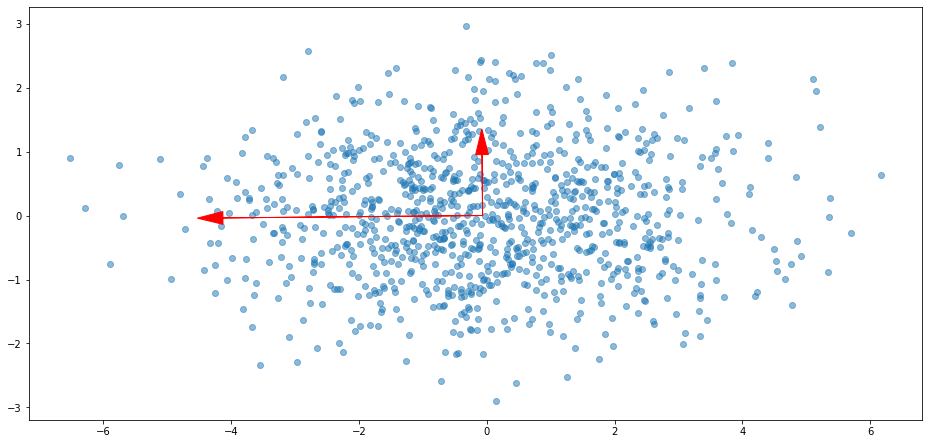

In [5]:
from sklearn.decomposition import PCA


def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var         #Per-feature empirical mean
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

Видим, что PCA правильно определил направление наибольшего разброса данных. Но это, конечно, можно было сделать, просто посчитав
дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим,
что для PCA это ничего не изменит.

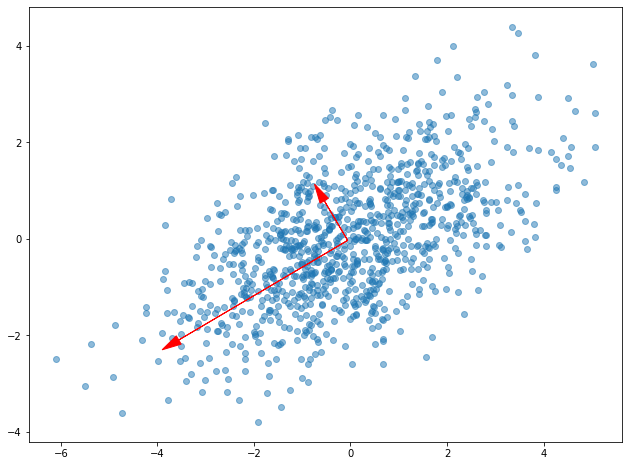

In [6]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже пара примеров, где PCA отработал не так хорошо (в том смысле, что направления задают не очень хорошие признаки, не отображающие структуру данных).

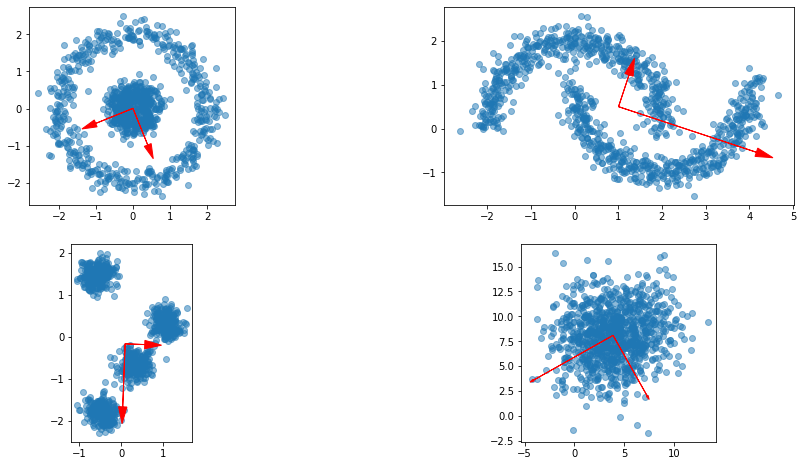

In [7]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)
data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[4, 8], 
        cov=[[9, 1], 
             [1, 8]],
        size=1000),
]


plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

#### Лица людей

Рассмотрим датасет с фотографиями лиц людей и применим к его признакам PCA.
https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset

Ниже изображены примеры лиц из базы, а последняя картинка &mdash; это "среднее лицо".

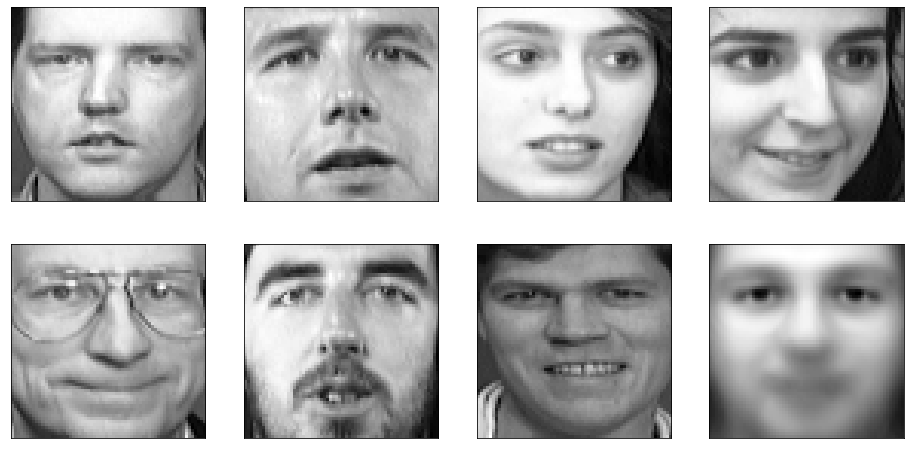

In [8]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты.

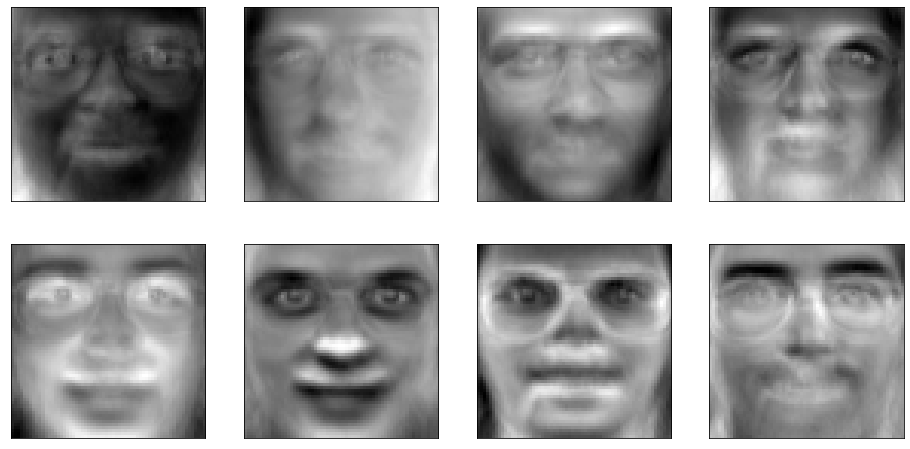

In [9]:
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

Во-первых, новые признаки дают более высокое качество классификации.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]},
                       cv=3)

In [11]:
%%time

gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

0.7547600344143942
CPU times: user 1min 15s, sys: 216 ms, total: 1min 15s
Wall time: 1min 15s


In [12]:
%%time

gscv_rf.fit(red.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.8973553286200575
CPU times: user 34.3 s, sys: 192 ms, total: 34.5 s
Wall time: 33.1 s


Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются
в новое пространство, и из него выкидываются самые незначимые признаки.

Ниже приведены результаты сжатия в 10 раз.

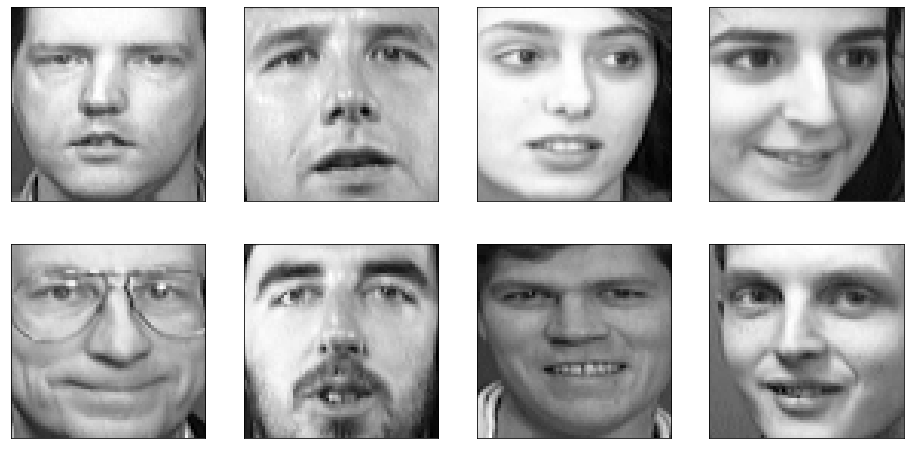

In [13]:
base_size = min(image_shape[0] * image_shape[1], faces_images.shape[0])

def compress_and_show(compress_ratio):
    red = PCA(n_components=int(base_size * compress_ratio))
    red.fit(faces_images)

    faces_compressed = red.transform(faces_images)
    faces_restored = red.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
compress_and_show(1)

И даже при сжатии в 20 раза лица остаются узнаваемыми.

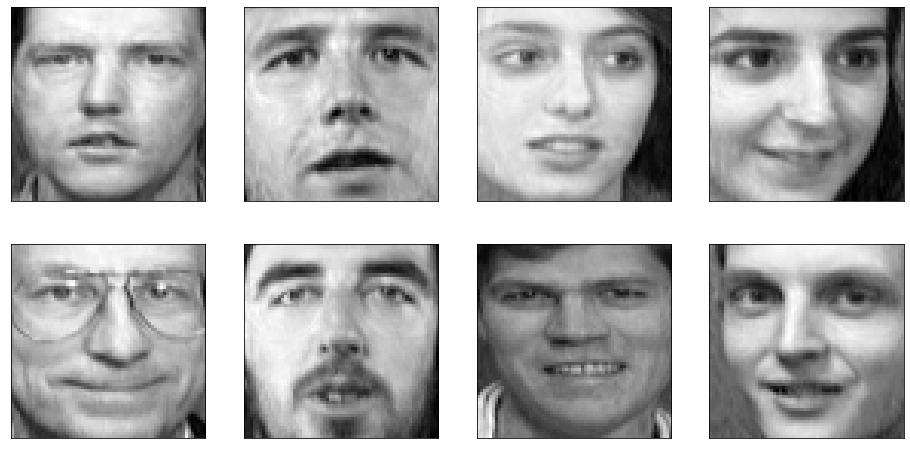

In [14]:
compress_and_show(0.5)

### Часть 2. Генерация признаков и общий план решения практических задач

За основу материала взят [ноутбук с Kaggle Kernels](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook), автор [@beluga](https://www.kaggle.com/gaborfodor).

В ноутбуке решается задача [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration), в которой по данным поездки на такси в Нью-Йорке необходимо предсказать продолжительность поездки. Для загрузки полных данных воспользуйтесь ссылкой на соревнование. Для занятия используется сокращенная версия данных с целью сократить время вычислений.



In [15]:
%matplotlib inline
import numpy as np
import pandas as pd 
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

#### Загрузка и простой анализ данных

In [16]:
train = pd.read_csv("train_sem_features.csv")
test = pd.read_csv("test_sem_features.csv")

Описание данных:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - duration of the trip in seconds

Конечно же, признаки dropoff_datetime and trip_duration доступны только для обучающей выборки.

In [17]:
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 100000 training rows and 50000 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3104769,2,2016-02-18 00:54:25,2016-02-18 01:20:38,1,-73.991730,40.745087,-73.909615,40.772057,N,1573
1,id2844283,1,2016-06-14 02:26:38,2016-06-14 02:39:39,1,-73.988205,40.718430,-73.886818,40.713310,N,781


Проанализируем id строк в обучении и контроле:

In [18]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values))== 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'N', 'Y'}.


Простейшая обработка данных: конвертируем признаки времени в datetime, бинаризуем признак, принимающий два значения:

In [19]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)


train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

Проверяем, что признаки и таргет согласуются между собой.

In [20]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).apply(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


Если посчитать максимальную длину поездки по всей выборке, то мы получит значение близкое к 1000 часов. Видимо, поэтому выбрана метрика [RMSLE](https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle) (MSE для логарифма целевой переменной). Логарифмируем целевую переменную, чтобы далее работать только с ней:

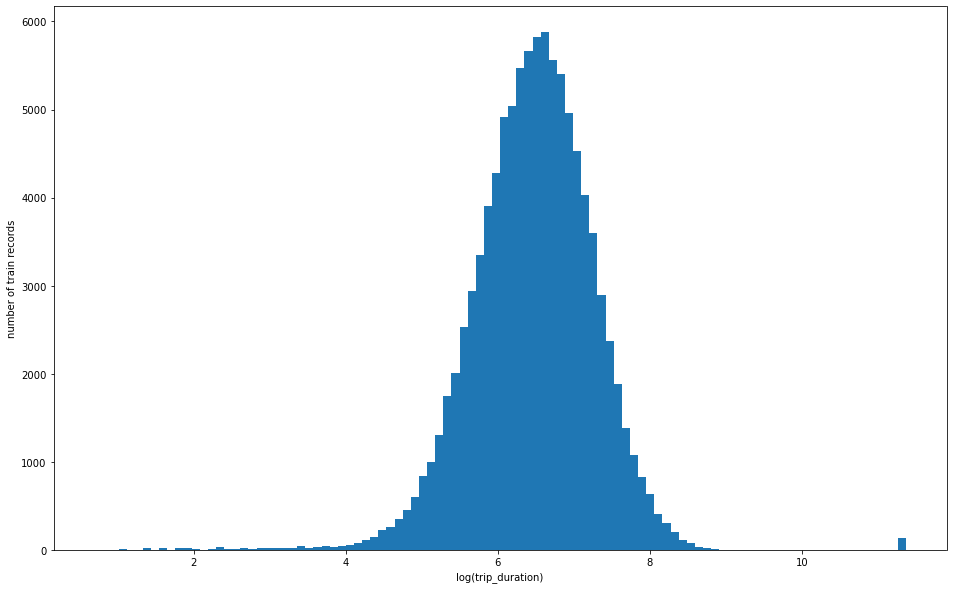

In [21]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

#### Выбор стратегии валидации

Проверяем разделение на обучение и контроль. Это позволит понять, как устраивать локальную валидацию модели, и поможет правильно выбрать, какие добавить признаки.

Какие дни присутствуют в обучении и контроле?

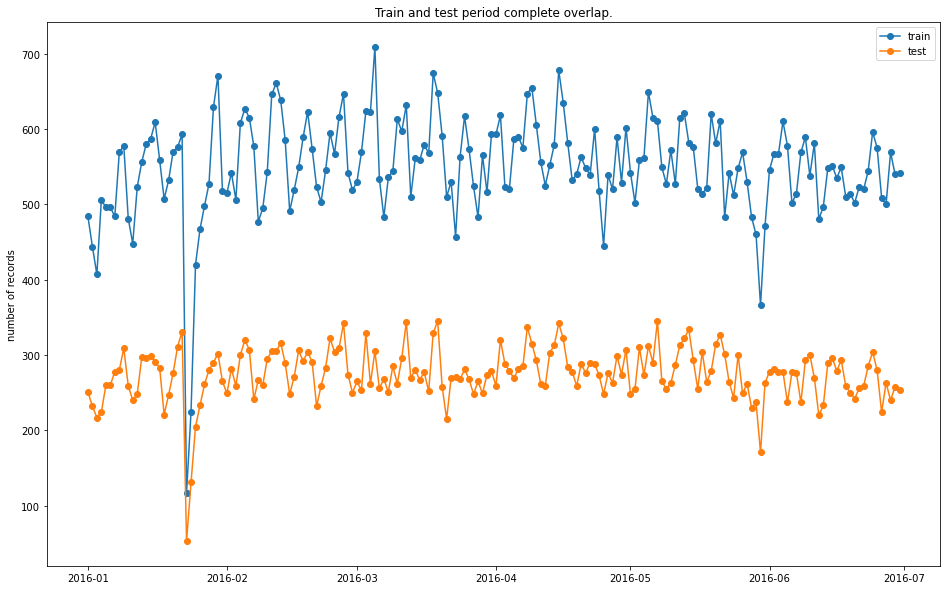

In [22]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

Какие координаты присутствуют в обучении и контроле?

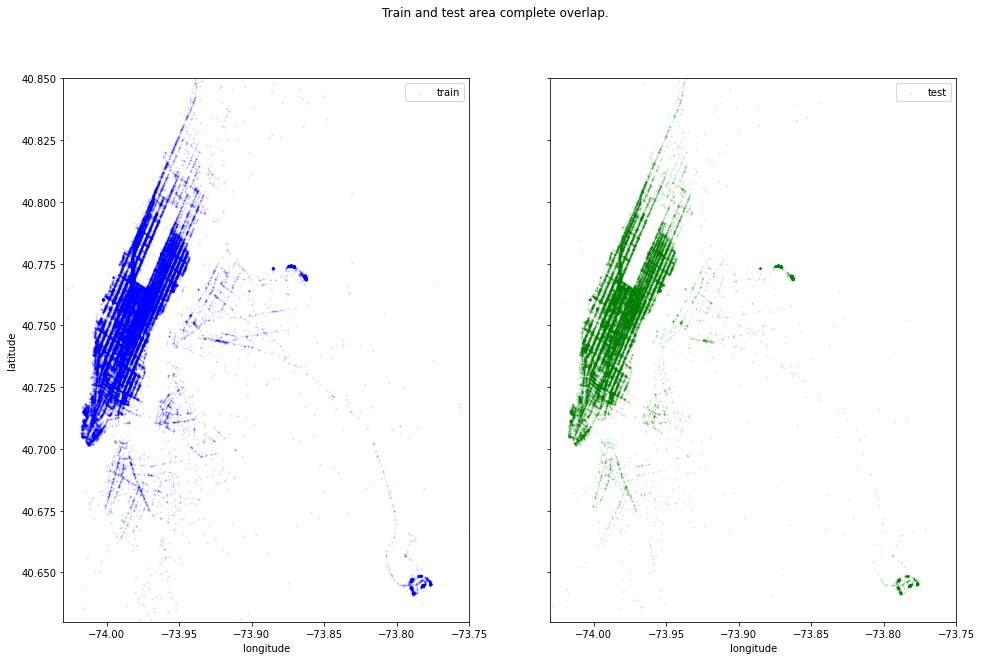

In [24]:
N = 1000000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], \
              train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], \
              test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Разделение на обучение и контроль случайное. Это позволяет не переживать насчет выделения локальных обучающей и контрольной выборок по времени или по координатам.

### Feature Extraction / Генерация новых признаков

#### Признаки расстояния. PCA
Используем PCA [[1](https://youtu.be/HMOI_lkzW08)] [[2](https://youtu.be/FgakZw6K1QQ)] для транформации широты и долготы. По утверждению автора ноутбука, поворот должен помочь найти лучшие разбиения в дереве. Уменьшение размерности мы здесь не делаем.

Примените PCA (уже импортирован). Следуйте инструкциям в ячейке.

In [25]:
# student's code here
ar1 = train[['pickup_latitude', 'pickup_longitude']].values
ar2 = train[['dropoff_latitude', 'dropoff_longitude']].values
ar3 = test[['pickup_latitude', 'pickup_longitude']].values
ar4 = test[['dropoff_latitude', 'dropoff_longitude']].values

# Соедините все четыре массива в один по вертикали (по "объектам")
coords = np.vstack((ar1, ar2, ar3, ar4))

# Создайте и обучите  PCA
pca = PCA().fit(coords)

# Применяем pca (вызываем transform и берем нулевой или первый столбец)
train['pickup_pca0'] = pca.transform(ar1)[:, 0]
train['pickup_pca1'] = pca.transform(ar1)[:, 1]
train['dropoff_pca0'] = pca.transform(ar2)[:, 0]
train['dropoff_pca1'] = pca.transform(ar2)[:, 1]
test['pickup_pca0'] = pca.transform(ar3)[:, 0]
test['pickup_pca1'] = pca.transform(ar3)[:, 1]
test['dropoff_pca0'] = pca.transform(ar4)[:, 0]
test['dropoff_pca1'] = pca.transform(ar4)[:, 1]

Визуализируем выполненную трансформацию с помощью PCA:

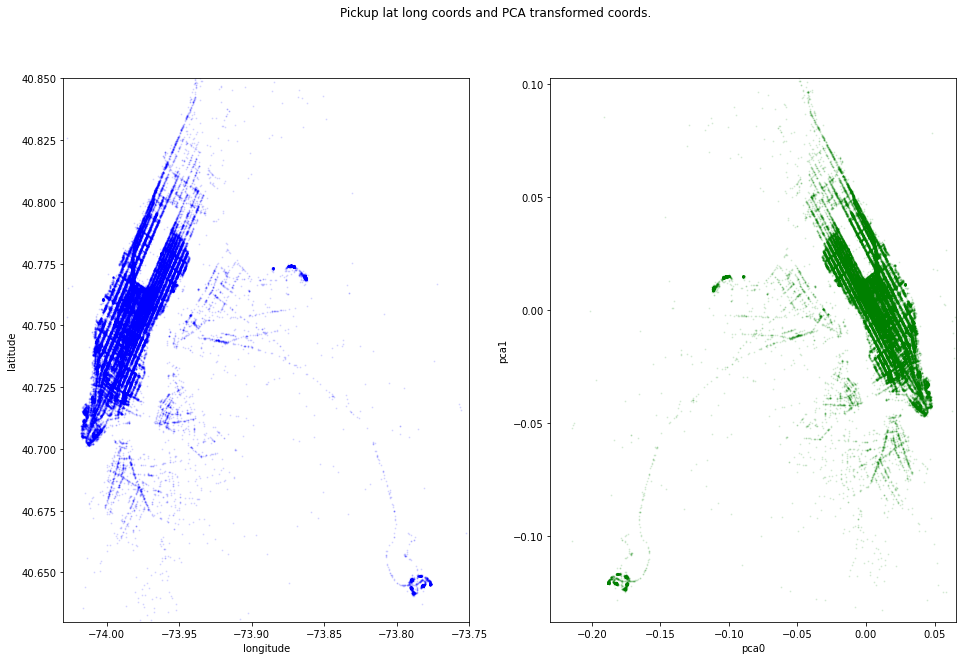

In [27]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

#### Признаки на основе кластеризации

Кластеризация помогает лучше понять структуру данных. Поэтому ее часто используют для задания новых признаков: кластеризуют объекты по уже имеющимся признакам, кластеризуют геопозиции или множественнозначные признаки. Выполним кластеризацию геопозиций, чтобы выделить "районы", и добавим признаки района прибытия и района отправления:

In [28]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

Добавьте признаки pickup_cluster и dropoff_cluster в обучающую и тестовую выборки:

In [29]:
# student's code here 
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])


Визуализируем полученные "районы":

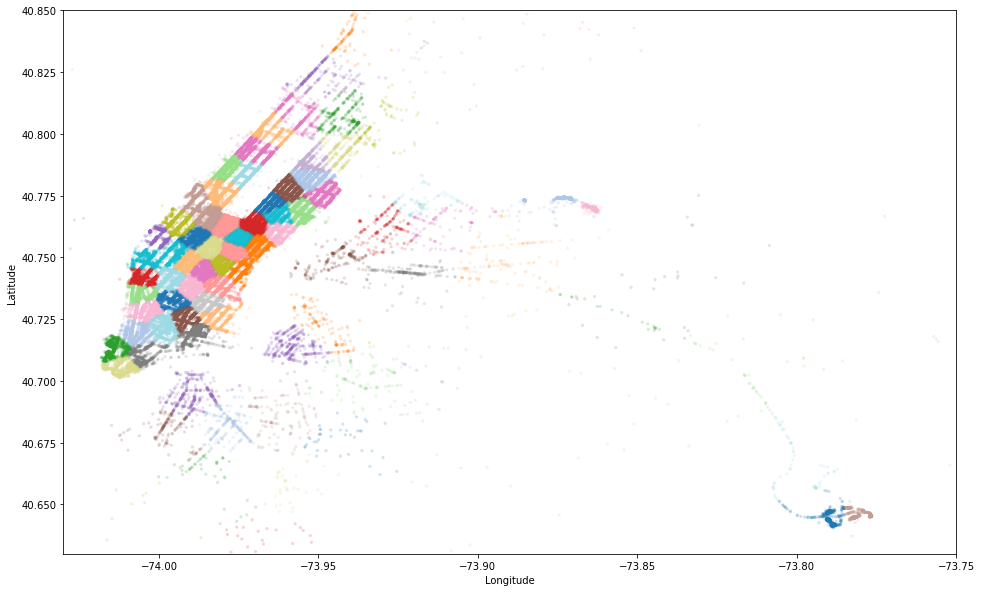

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

#### Признаки расстояния

Вычислим расстояния между местом посадки и высадки. Ниже используются сложные функции расстояния, не стоит сильно вникать в их код.  К примеру, используется расстояние на сфере - [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). Кроме того, код вычисляет среднюю точку маршрута как дополнительный признак.

Цитата автора ноубука:

The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :) 

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train['distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test['distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train['center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train['center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test['center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test['center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

#### Признаки времени

Посчитаем простые функции по времени: выделим день недели, час, время, сравним дни и часы высадки и посадки:

In [ ]:
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

#### Скорость
Скорость - простой производный признак от двух предыдущих.

Вычислите скорость для трех функций расстояния. Вам понадобятся следующие признаки: distance_haversine, distance_dummy_manhattan, distance_manhattan, trip_duration.

In [ ]:
# student's code here
train.loc[: ,'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

Посмотрим на скорость как на функцию от времени:

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

Посмотрим на скорость как на функцию от геопозиции:

In [ ]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
#coord_stats = coord_stats[coord_stats['id'] > 100]
plt.scatter(train.pickup_longitude.values, train.pickup_latitude.values,
           color='black', s=1, alpha=0.5)
plt.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=0, vmax=0.02)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average speed')
plt.colorbar()
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

#### Агрегация по времени и району

Добавим признаки, характеризующие среднюю скорость в данный момент времени или в данном (условном) районе. Таким образом мы закодируем категориальные признаки и добавим полезную информацию о поездке. 
Также добавим признаки средней скорости в комбинации район-момент времени, при этом удаляя редкие значения комбинации.

Важно, что в задаче не нужно учитывать разделение выборки по времени или по геопозиции, иначе к заданию указанных признаков нужны было бы подходить осторожнее.

In [ ]:
# перебираем категориальные признаки, которые будем кодировать
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    # вычисляем среднюю скорость и среднюю продолжительность поездки
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    # задаем имена новых признаков
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    # добавляем новые признаки: одно и то же значение из gby будет вставлено в несколько строк train и test
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

# перебираем комбинации локация-момент времени и локация-локация
for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    # вычисляем среднюю скорость и число объектов для комбинации
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    # удаляем редкие значения комбинации
    coord_stats = coord_stats[coord_stats['id'] > 100]
    # задаем имена новых стобцов
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    # добавляем новые признаки
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

В оригинальном ноутбуке автор добавляет еще несколько интересных прзнаков:
- число поездок в течение часа
- числи поездок *из* и *в* точки конкретного кластера

Далее автор ноутбука выполняет проверку признаков, обучает модель, анализирует важности признаков и делает подбор гиперпараметров. Мы не будем запускать эти операции на занятии, а просто посмотрим на результат в [оригинальном ноутбуке](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367/notebook).

На что обратить внимание:

- Перед Feature check before modeling удаляются ненужные признаки: ID, дата (из нее извлекли всю информацию), pickup_lat_bin и pickup_lon_bin (они использовались для задания других признаков) и т. д.. Также задается целевая перемнная.

- В секции Feature check before modeling производится проверка, есть ли пропуски в данных и велик ли разрыв между обучающей и тестовой выборкой. Второе нужно, чтобы удостовериться, что распределение данных в обучении и тесте похожее, а также позволяет проверить, что в коде генерации признаков (вероятно) нет ошибок.

- В секции Modeling строится базовая модель xgboost с некоторыми гиперпараметрами и максимум 60 деревьями, выводится качество этой модели (используется метрика задачи).

- В секции Feature importance analysis автор ноутбука смотрит, какие важности присвоены признакам моделью. Важности довольно интерпретируемы: например, расстояние и место посадки сильно влияет на целевую переменную (время поездки), а vendor_id и store_and_fwd_flag - неважные признаки. Среди важных признаков много сгенерированных в процессе feature engineering.  Автор предлагает также посмотреть на другую характеристику важности признака - качество модели, построенной на всех данных, кроме признака. Данная мера качества не всегда совпадает с важностями, выданными xgboost, хотя в целом коррелирует. Стоит аккуратно относиться к важностям признаков, так как ни один метод не является "точно правильным".

- В секции XGB Parameter Search Result автор задает большую сетку гиперпараметров и поочередно выбирает случайную комбинацию. Такой случайный поиск позволяет покрыть разнообразные комбинации и найти хорошую область гиперпараметров.